# House Price prediction with AutoML (Accelerated Data Science Python SDK)

In [52]:
# Load a number of libraries, including the Accelerated Data Science DatasetFactory
# Load the House Price data set using the ADS library. 
# This library is capable of loading data from a variety of sources, including OCI Object Storage, 
# Autonomous Database (ADW and ATP), other Oracle databases, Hadoop, S3, and many more. 
# In this case the file is simply loaded from the block storage of the OCI Data Science service 
# itself.
import pandas as pd
import logging
import numpy as np
from sklearn import preprocessing
from ads.dataset.factory import DatasetFactory
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
ds = DatasetFactory.open("housesales.csv", target="SalePrice")

In [18]:
# Automatic Data Preparation with ADS:
# Last time we investigated every feature to decide whether it needed to be included in the model 
# training. We manually had to check for things like number of unique values and missing values.
# Instead of doing this manually, let's ask ADS for suggestions on what changes to make to the
# data set.
# The following will show a summary of the recommendations. For example, ADS can recommend how 
# to handle missing values. And it will recommend what to do with columsn that appear identifiers.
suggestion_df = ds.suggest_recommendations()

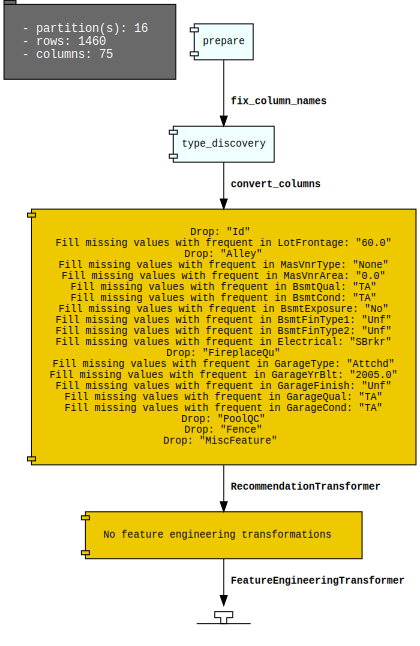

In [47]:
# Imagine that we decide to simply take the recommendations made by ADS. Before we run the 
# transformations, let's have a look at the original situation.
# For example, ADS suggests that we drop the columns Id, Alley, FireplaceQu, et ceters.
# ADS also suggests that we set default values for missing values in LotFrontage, MasVnrArea, 
# et cetera.
# Now, let's apply the recommended transformations.
# We will also visualize the transformations.
ds_transformed = ds.auto_transform()
ds_transformed.visualize_transforms()

In [48]:
# Let's visualize the end result.
# We see that there are now only 74 features left.
ds_transformed.summary()

,Feature,Datatype
0,SalePrice,ordinal/int32
1,MSSubClass,ordinal/int16
2,MSZoning,categorical/category
3,LotFrontage,ordinal/float64
4,LotArea,ordinal/int32
5,Street,categorical/category
6,LotShape,categorical/category
7,LandContour,categorical/category
8,Utilities,categorical/category
9,LotConfig,categorical/category


In [28]:
# AutoML:
# Now let's move on to building the model.
# We will run an experiment in which we create 3 models:
# 1: Linear Regression manually configured
# 2: Ridge Regression manually configured
# 3: AutoML
# Once we've trained the models, we will compare their performance.
#
# Preparation:
# 1. Resolve the skew in the target SalePrice by doing a log operation.
ds_transformed = ds_transformed.assign_column('SalePrice', lambda x: np.log(x))
# 2. Convert categorical attributes to numeric attributes
from ads.dataset.label_encoder import DataFrameLabelEncoder
ds_encoded = DataFrameLabelEncoder().fit_transform(ds_transformed.to_pandas_dataframe())
# 3. Separate the dataset in target and input features and split into test and train.
y = ds_encoded['SalePrice']
X = ds_encoded.drop(['SalePrice'], axis=1)
ds_done = DatasetFactory.open(ds_encoded, target="SalePrice")
train, test = ds_done.train_test_split(test_size=0.2)

In [44]:
# First train two models manually (without AutoML): Linear Regression and Ridge Regression.
# We'll use these later to compare their performance against AutoML.
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from ads.common.model import ADSModel
X = train.X.copy()
y = train.y.copy()
lr = LinearRegression()
rr = Ridge(alpha=13.5)
lr_model_fit = lr.fit(X, y)
rr_model_fit = rr.fit(X, y)
lr_model = ADSModel.from_estimator(lr_model_fit, name="LinearRegression")
rr_model = ADSModel.from_estimator(rr_model_fit, name="Ridge")


In [45]:
# Now, let's see how well AutoML can perform the same task.
# AutoML will evaluate several algorithms in combination with different values for their 
# hyperparameters.
# Note that AutoML can take up to a few minutes (depending on the selected shape).
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
ml_engine = OracleAutoMLProvider(n_jobs = -1) # n_jobs = -1 means that we are not going to limit the resources and let the AutoML to do this for us and take as much as possible
automl = AutoML(train, provider=ml_engine)
model, baseline = automl.train(time_budget=160, random_state=42)


Training Dataset size,"(1148, 74)"
Validation Dataset size,None
CV,"[([0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 50, 52, 53, 55, 57, 60, 61, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 77, 79, 80, 81, 82, 84, 85, 87, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 102, 103, 104, 105, 106, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, ...], [3, 10, 23, 30, 31, 39, 44, 49, 51, 54, 56, 58, 59, 63, 70, 76, 78, 83, 86, 88, 96, 100, 101, 107, 109, 113, 128, 136, 138, 139, 140, 141, 156, 158, 168, 170, 174, 178, 192, 198, 199, 208, 209, 210, 218, 220, 231, 240, 242, 243, 244, 247, 260, 270, 277, 286, 291, 292, 294, 299, 306, 308, 309, 318, 321, 327, 331, 333, 342, 344, 351, 354, 359, 361, 362, 363, 367, 377, 381, 394, 398, 405, 411, 413, 424, 427, 433, 436, 442, 445, 447, 453, 460, 464, 465, 467, 478, 485, 494, 506, ...]), ([0, 1, 3, 4, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 3..."
Target variable,SalePrice
Optimization Metric,neg_mean_squared_error
Initial number of Features,74
Selected number of Features,71
Selected Features,"[MSSubClass, MSZoning, LotFrontage, LotArea, Street, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, MiscVal, MoSold, YrSold, SaleType, SaleCondition]"
Selected Algorithm,LGBMRegressor
End-to-end Elapsed Time (seconds),106.7
Selected Hyperparameters,"{'boosting_type': 'gbdt', 'colsample_bytree': 0.5029790303129982, 'max_depth': 63, 'n_estimators': 100, 'num_leaves': 7, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,LGBMRegressor_HT,1148,71,-1.1016e-04,"{'boosting_type': 'gbdt', 'colsample_bytree': 0.5029790303129982, 'max_depth': 63, 'n_estimators': 100, 'num_leaves': 8, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",1.9180
3,LGBMRegressor_HT,1148,71,-1.1203e-04,"{'boosting_type': 'gbdt', 'colsample_bytree': 0.5029790303129982, 'max_depth': 63, 'n_estimators': 101, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",4.2389
4,LGBMRegressor_HT,1148,71,-1.1209e-04,"{'boosting_type': 'gbdt', 'colsample_bytree': 0.5029790303129982, 'max_depth': 63, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 1.5390650101008513e-06, 'subsample': 1}",4.4264
5,LGBMRegressor_HT,1148,71,-1.1209e-04,"{'boosting_type': 'gbdt', 'colsample_bytree': 0.5029790303129982, 'max_depth': 63, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5804187102089685}",4.4246
6,LGBMRegressor_HT,1148,71,-1.1209e-04,"{'boosting_type': 'gbdt', 'colsample_bytree': 0.5029790303129982, 'max_depth': 63, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.4899075413427271}",4.3603
...,...,...,...,...,...,...
182,LGBMRegressor_HT,1148,71,-3.6362e-02,"{'boosting_type': 'dart', 'colsample_bytree': 0.5029790303129982, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 8, 'reg_alpha': 0.005623553830557401, 'reg_lambda': 1.8784127778939314e-05, 'subsample': 0.48990254134272715}",1.5716
183,LGBMRegressor_HT,1148,71,-3.6387e-02,"{'boosting_type': 'dart', 'colsample_bytree': 0.4, 'max_depth': 2, 'n_estimators': 100, 'num_leaves': 7, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10, 'subsample': 0.4}",1.2296
184,LinearRegression_AS,1148,74,-7.7567e+18,{},0.5517
185,LGBMRegressor_HT,1148,71,-1.0916e+52,"{'boosting_type': 'goss', 'colsample_bytree': 1, 'max_depth': 63, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}",2.6950


In [50]:
# AutoML has selected the LGBMRegressor_HT algorithm with a subset of 71 features.
#
# Let's compare the performance of the manual and AutoML models
print("Linear Score: {}\nRidge Score: {}".format(lr_model.score(train.X, train.y), 
                                                    rr_model.score(train.X, train.y)))
print("AutoML Score: {}".format(model.score(train.X, train.y)))


Linear Score: 0.9150638438041108
Ridge Score: 0.9138355931893684
AutoML Score: -4.888519658768526e-05


In [71]:
# Conclusion:
# AutoML performs significantly better than our manually configured models!
#

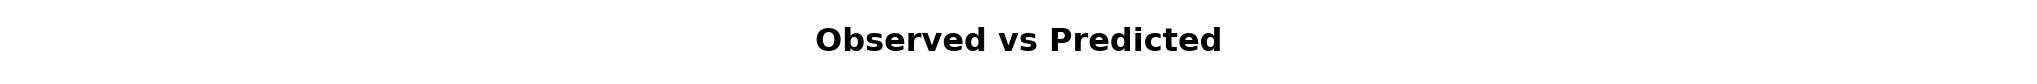

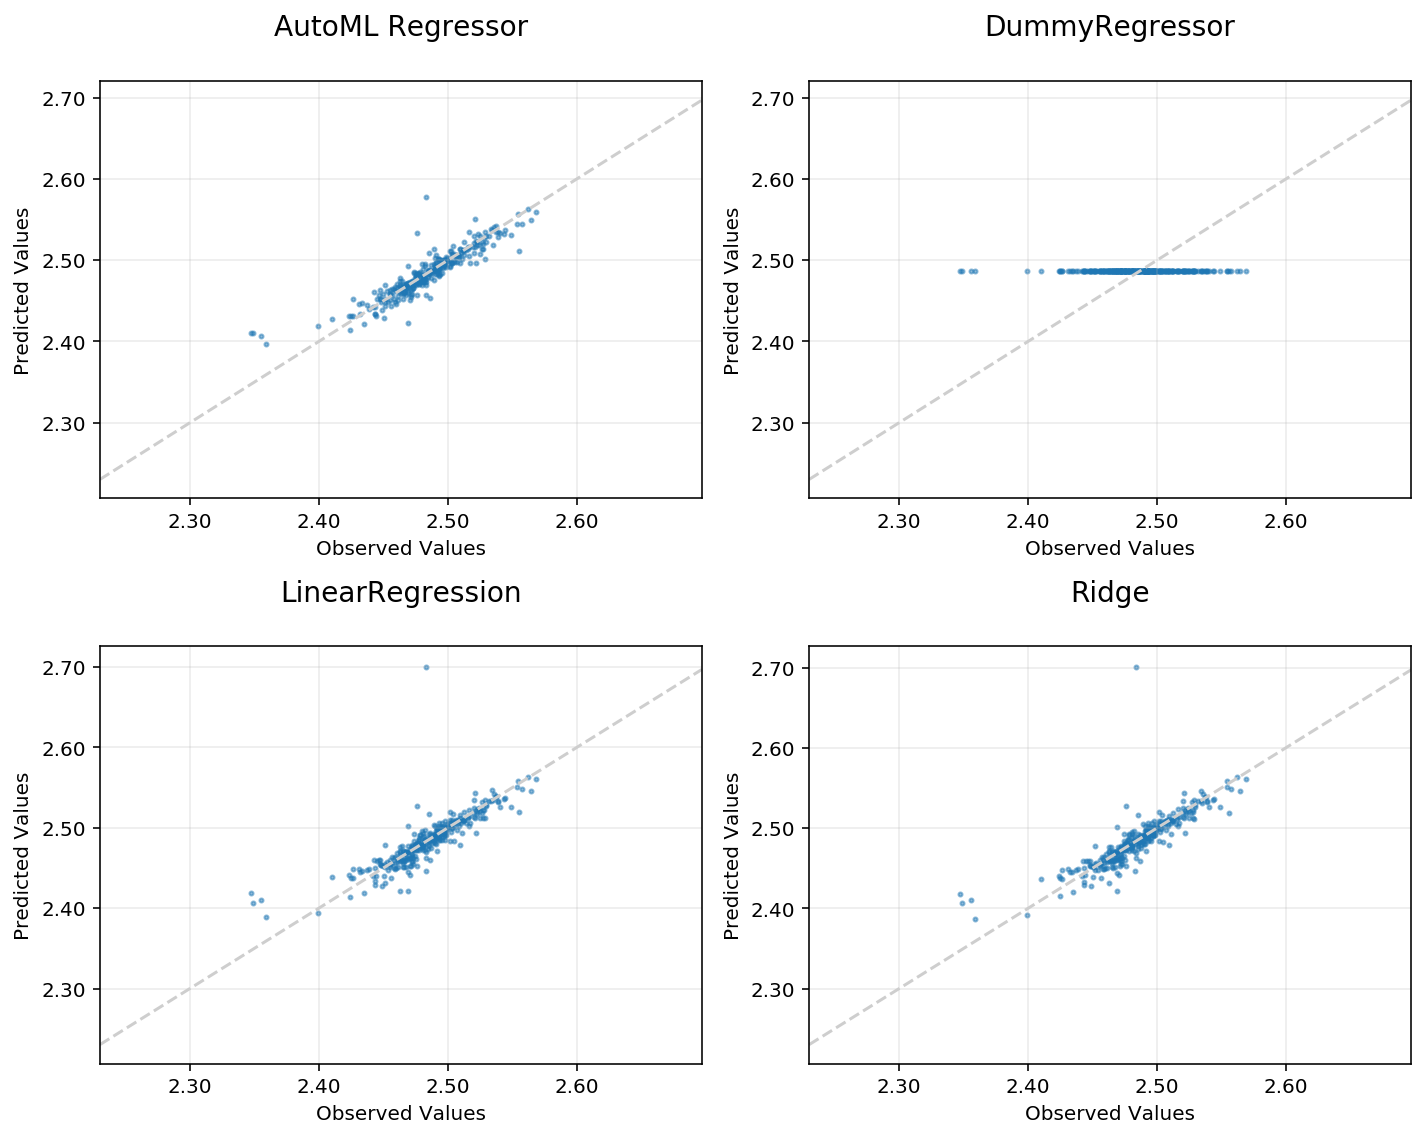

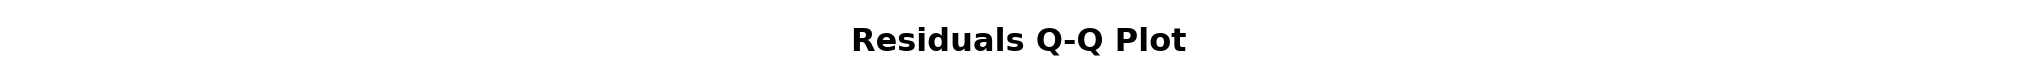

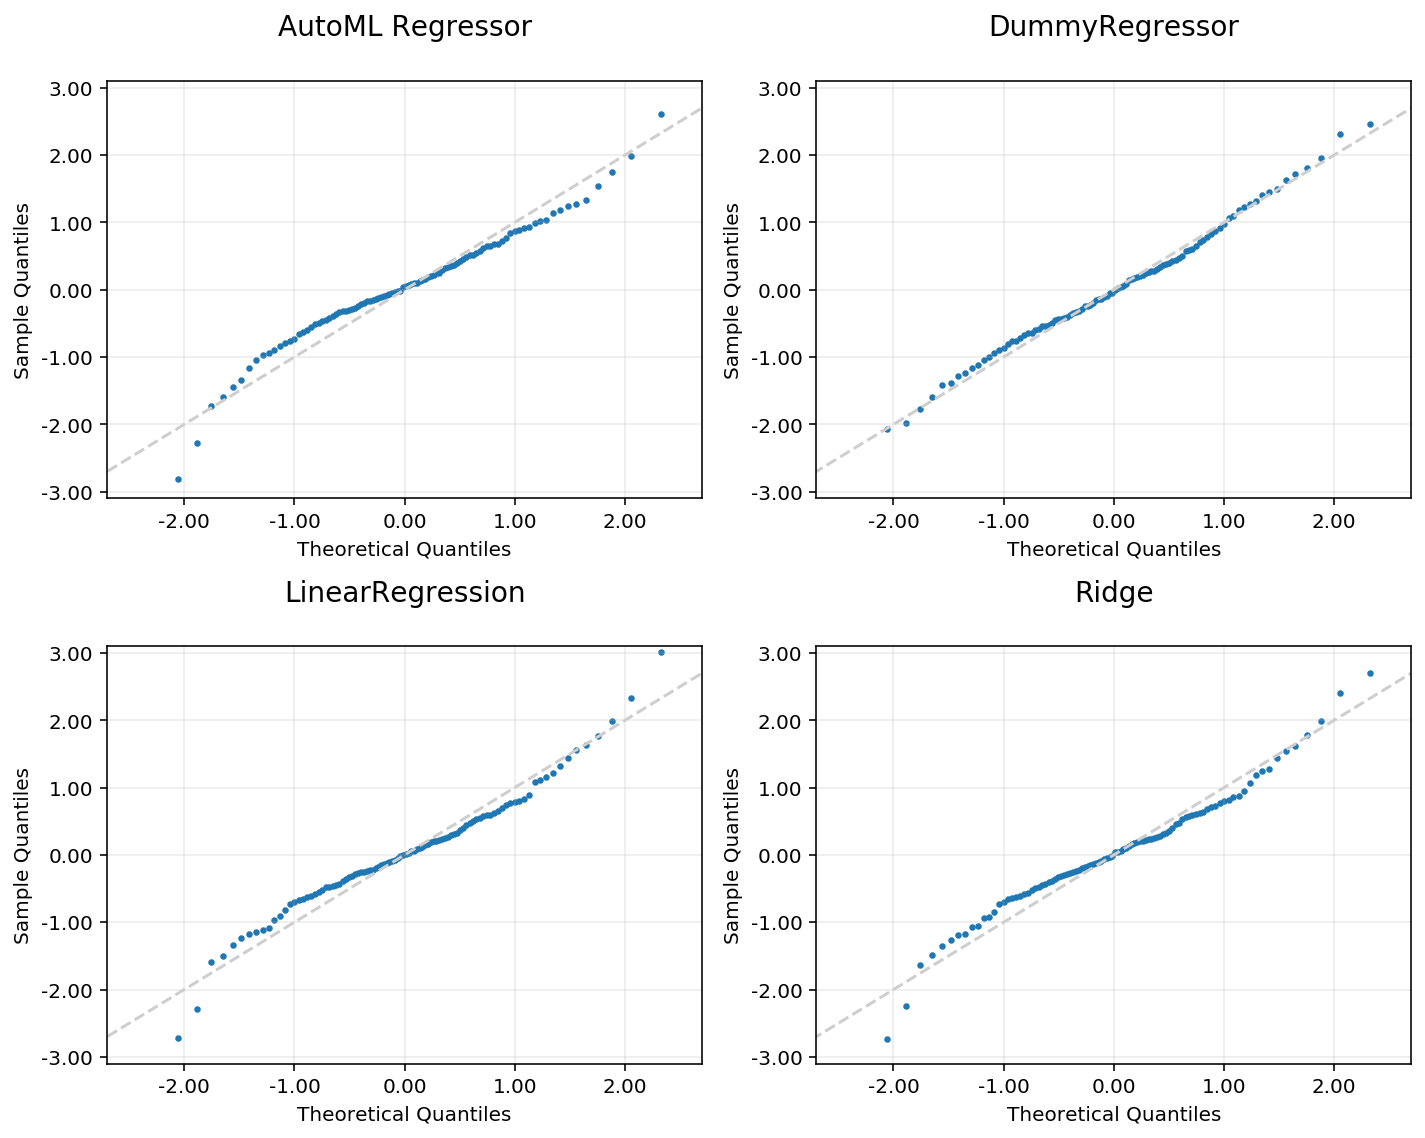

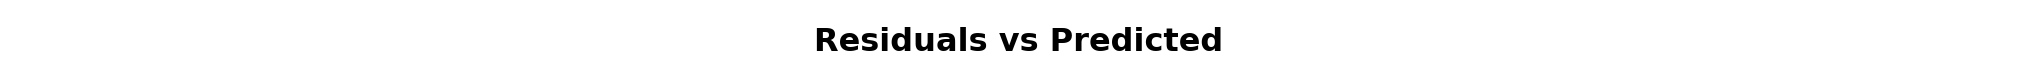

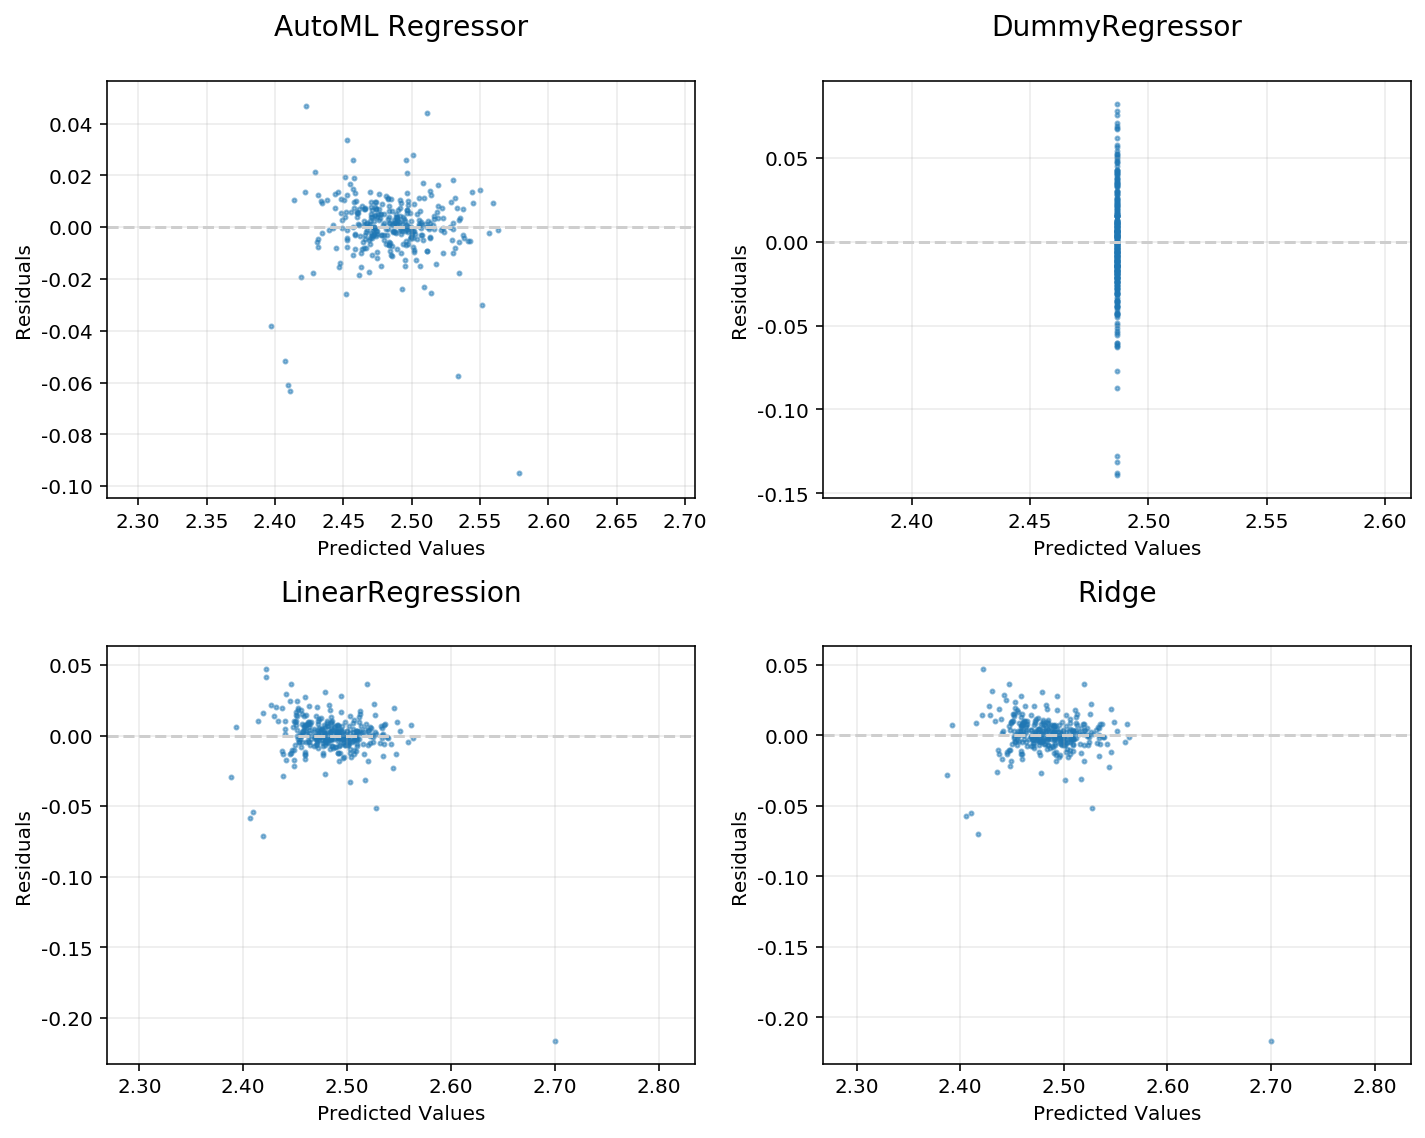

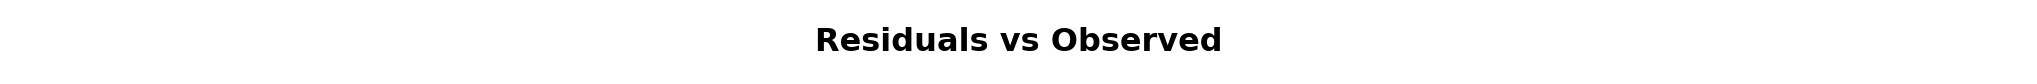

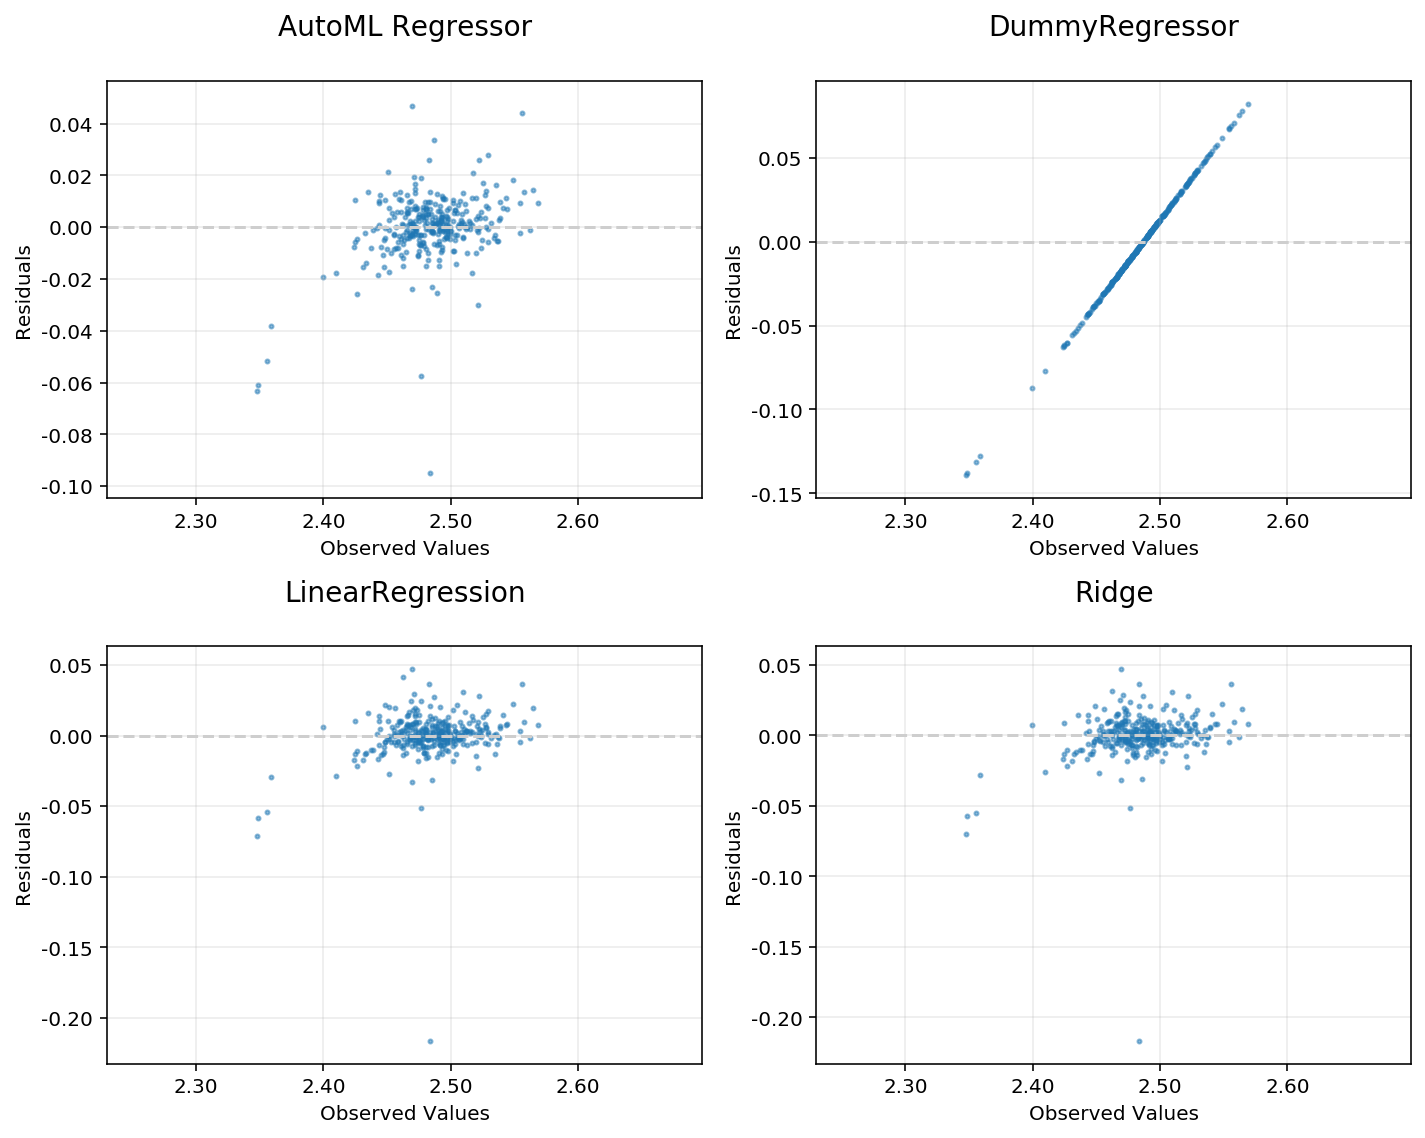

In [49]:
# Optional: Take a visual approach to comparing the 3 models
# ADS can automatically create graphs to compare the performance of models in a variety of ways 
# (Observed vs Predicted, Residuals Q-Q Plot, Residuals vs Predicted, Residuals vs Observed).
from ads.evaluations.evaluator import ADSEvaluator
evaluator = ADSEvaluator(test, models=[model, baseline, lr_model, rr_model], training_data=train)
evaluator.show_in_notebook()